## A. Library Imports and Visualization Settings

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import kagglehub
import os

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## B. Loading World Happiness Data (2015–2022)

In [3]:
data_path = kagglehub.dataset_download("mathurinache/world-happiness-report")
print(f"Data downloaded to: {data_path}")

years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
dataframes = {}

for year in years:
    file_path = f"{data_path}/{year}.csv"
    df = pd.read_csv(file_path, encoding="utf-8")
    dataframes[year] = df
    print(f"{year} data loaded: {df.shape[0]} countries, {df.shape[1]} columns")

print(f"\nData for the total of {len(dataframes)} years has been loaded.")

Data downloaded to: /Users/melisatay/.cache/kagglehub/datasets/mathurinache/world-happiness-report/versions/2
2015 data loaded: 158 countries, 12 columns
2016 data loaded: 157 countries, 13 columns
2017 data loaded: 155 countries, 12 columns
2018 data loaded: 156 countries, 9 columns
2019 data loaded: 156 countries, 9 columns
2020 data loaded: 153 countries, 20 columns
2021 data loaded: 149 countries, 20 columns
2022 data loaded: 147 countries, 12 columns

Data for the total of 8 years has been loaded.


## C. Inspecting Dataset Structure and Columns

In [4]:
for year in years:
    print(f"\n{year} Columns:")
    print(dataframes[year].columns.tolist())
    print(f"First 5 columns:")
    print(dataframes[year].head(3))
    print("-" * 50)


2015 Columns:
['Country', 'Region', 'Happiness Rank', 'Happiness Score', 'Standard Error', 'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual']
First 5 columns:
       Country          Region  Happiness Rank  Happiness Score  \
0  Switzerland  Western Europe               1            7.587   
1      Iceland  Western Europe               2            7.561   
2      Denmark  Western Europe               3            7.527   

   Standard Error  Economy (GDP per Capita)   Family  \
0         0.03411                   1.39651  1.34951   
1         0.04884                   1.30232  1.40223   
2         0.03328                   1.32548  1.36058   

   Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
0                   0.94143  0.66557                        0.41978   
1                   0.94784  0.62877                        0.14145   
2                   0.87464  0.64938   

## D. Data Cleaning, Standardization, and Dataset Integration

In [5]:
def clean_and_standardize(df, year):

    df_clean = df.copy()

    df_clean['Year'] = year
    
    column_mapping = {

        'Country': 'Country',
        'Country or region': 'Country',  # 2018, 2019
        'Country name': 'Country',  # 2020, 2021

        'RANK': 'Rank',
        'Happiness Rank': 'Rank',
        'Rank': 'Rank',
        'Overall rank': 'Rank',  # 2018, 2019

        'Happiness score': 'Happiness_Score',
        'Happiness Score': 'Happiness_Score',
        'Happiness.Score': 'Happiness_Score',
        'Score': 'Happiness_Score',  # 2018, 2019
        'Ladder score': 'Happiness_Score',  # 2020, 2021

        'Explained by: GDP per capita': 'GDP_per_capita',
        'Explained by: Log GDP per capita': 'GDP_per_capita',  # 2020, 2021
        'Economy (GDP per Capita)': 'GDP_per_capita',
        'Economy..GDP.per.Capita.': 'GDP_per_capita',
        'GDP per capita': 'GDP_per_capita',  # 2018, 2019
        'Logged GDP per capita': 'GDP_per_capita',  # 2020, 2021 

        'Explained by: Social support': 'Social_support',
        'Family': 'Social_support',
        'Social.support': 'Social_support',
        'Social support': 'Social_support',  # 2018, 2019, 2020, 2021
    
        'Explained by: Healthy life expectancy': 'Life_expectancy',
        'Health (Life Expectancy)': 'Life_expectancy',
        'Health..Life.Expectancy.': 'Life_expectancy',
        'Healthy life expectancy': 'Life_expectancy',  # 2018, 2019, 2020, 2021

        'Explained by: Freedom to make life choices': 'Freedom',
        'Freedom': 'Freedom',
        'Freedom.to.make.life.choices': 'Freedom',
        'Freedom to make life choices': 'Freedom',  # 2018, 2019, 2020, 2021

        'Explained by: Generosity': 'Generosity',
        'Generosity': 'Generosity',  # 2018, 2019, 2020, 2021

        'Explained by: Perceptions of corruption': 'Corruption',
        'Trust (Government Corruption)': 'Corruption',
        'Perceptions.of.corruption': 'Corruption',
        'Perceptions of corruption': 'Corruption',  # 2018, 2019, 2020, 2021

        'Region': 'Region',
        'Regional indicator': 'Region'  # 2020, 2021
    }
    

    df_clean = df_clean.rename(columns=column_mapping)
    

    numeric_columns = ['Happiness_Score', 'GDP_per_capita', 'Social_support', 
                      'Life_expectancy', 'Freedom', 'Generosity', 'Corruption', 'Rank']
    
    for col in numeric_columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str).str.replace(',', '.')
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    required_columns = ['Year', 'Country', 'Rank', 'Happiness_Score', 
                       'GDP_per_capita', 'Social_support', 'Life_expectancy', 
                       'Freedom', 'Generosity', 'Corruption']

    available_columns = [col for col in required_columns if col in df_clean.columns]
    df_clean = df_clean[available_columns]
    
    return df_clean


cleaned_dataframes = {}
for year in years:
    try:
        cleaned_dataframes[year] = clean_and_standardize(dataframes[year], year)
        print(f"{year} year cleared: {cleaned_dataframes[year].shape} - {len(cleaned_dataframes[year])} country")
        
        if len(cleaned_dataframes[year]) == 0:
            print(f"Warning: No countries were found in {year}!")
            print(f"Original columns: {list(dataframes[year].columns)}")
    except Exception as e:
        print(f"Error: An error occurred while clearing the year {year}: {e}")
        print(f"Original columns: {list(dataframes[year].columns)}")


print("\nAll data has been cleared.")

2015 year cleared: (158, 10) - 158 country
2016 year cleared: (157, 10) - 157 country
2017 year cleared: (155, 8) - 155 country
2018 year cleared: (156, 10) - 156 country
2019 year cleared: (156, 10) - 156 country
Error: An error occurred while clearing the year 2020: 'DataFrame' object has no attribute 'str'
Original columns: ['Country name', 'Regional indicator', 'Ladder score', 'Standard error of ladder score', 'upperwhisker', 'lowerwhisker', 'Logged GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Ladder score in Dystopia', 'Explained by: Log GDP per capita', 'Explained by: Social support', 'Explained by: Healthy life expectancy', 'Explained by: Freedom to make life choices', 'Explained by: Generosity', 'Explained by: Perceptions of corruption', 'Dystopia + residual']
Error: An error occurred while clearing the year 2021: 'DataFrame' object has no attribute 'str'
Original columns: ['Country nam

In [6]:
df_combined = pd.concat(cleaned_dataframes.values(), ignore_index=True)

print("Combined dataset:")
print(f"Total number of rows: {len(df_combined)}")
print(f"Total number of columns: {len(df_combined.columns)}")
print(f"Years: {sorted(df_combined['Year'].unique())}")

print(f"\nCountry numbers by year:")
year_counts = df_combined.groupby('Year')['Country'].count()
for year in sorted(df_combined['Year'].unique()):
    count = year_counts.get(year, 0)
    print(f" {year}: {count} countries")

print(f"\nTop 5 line:")

df_combined.head()

Combined dataset:
Total number of rows: 929
Total number of columns: 10
Years: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2022)]

Country numbers by year:
 2015: 158 countries
 2016: 157 countries
 2017: 155 countries
 2018: 156 countries
 2019: 156 countries
 2022: 147 countries

Top 5 line:


,Year,Country,Rank,Happiness_Score,GDP_per_capita,Social_support,Life_expectancy,Freedom,Generosity,Corruption
0,2015,Switzerland,1.0,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978
1,2015,Iceland,2.0,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145
2,2015,Denmark,3.0,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357
3,2015,Norway,4.0,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503
4,2015,Canada,5.0,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957


## E. Handling Missing Values Using Country and Year Level Averages

In [7]:
missing_values = df_combined.isnull().sum()
print(missing_values[missing_values > 0])

print(f"\nTotal percentage of missing values: {(df_combined.isnull().sum().sum() / (len(df_combined) * len(df_combined.columns))) * 100:.2f}%")

Rank               155
Happiness_Score      1
GDP_per_capita       1
Social_support       1
Life_expectancy      1
Freedom              1
Generosity           1
Corruption         157
dtype: int64

Total percentage of missing values: 3.42%


In [8]:
for col in ['GDP_per_capita', 'Social_support', 'Life_expectancy', 'Freedom', 'Generosity', 'Corruption']:
    if col in df_combined.columns:
        df_combined[col] = df_combined.groupby('Country')[col].transform(
            lambda x: x.fillna(x.mean())
        )
        df_combined[col] = df_combined.groupby('Year')[col].transform(
            lambda x: x.fillna(x.mean())
        )
        df_combined[col] = df_combined[col].fillna(df_combined[col].mean())

df_combined['Rank'] = df_combined.groupby('Year')['Happiness_Score'].rank(ascending=False, method='min')


In [9]:
print(f"\nDataset size: {df_combined.shape}")
print(f"\nColumns: {list(df_combined.columns)}")
print(f"\nData types:")
print(df_combined.dtypes)
print(f"\nBasic statistics:")
df_combined.describe()


Dataset size: (929, 10)

Columns: ['Year', 'Country', 'Rank', 'Happiness_Score', 'GDP_per_capita', 'Social_support', 'Life_expectancy', 'Freedom', 'Generosity', 'Corruption']

Data types:
Year                 int64
Country                str
Rank               float64
Happiness_Score    float64
GDP_per_capita     float64
Social_support     float64
Life_expectancy    float64
Freedom            float64
Generosity         float64
Corruption         float64
dtype: object

Basic statistics:


,Year,Rank,Happiness_Score,GDP_per_capita,Social_support,Life_expectancy,Freedom,Generosity,Corruption
count,929.000000,928.000000,928.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000
mean,2017.785791,77.867457,5.406481,0.994278,1.051092,0.608263,0.427885,0.207310,0.131157
std,2.243374,44.758162,1.122392,0.447231,0.328068,0.238413,0.156513,0.119747,0.110139
min,2015.000000,1.000000,2.404000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,39.000000,4.534750,0.682000,0.851880,0.443000,0.325708,0.120000,0.056000
50%,2017.000000,78.000000,5.377000,1.029000,1.089000,0.641022,0.448000,0.190134,0.098000
75%,2019.000000,116.250000,6.218750,1.318570,1.285480,0.790828,0.547509,0.264280,0.163513
max,2022.000000,158.000000,7.821000,2.209000,1.644000,1.141000,0.740000,0.838075,0.587000


## F. Exploratory Data Analysis: Trends and Patterns in World Happiness

### F.1 Dataset Coverage Over Time

Year
2015    158
2016    157
2017    155
2018    156
2019    156
2022    147
Name: Country, dtype: int64


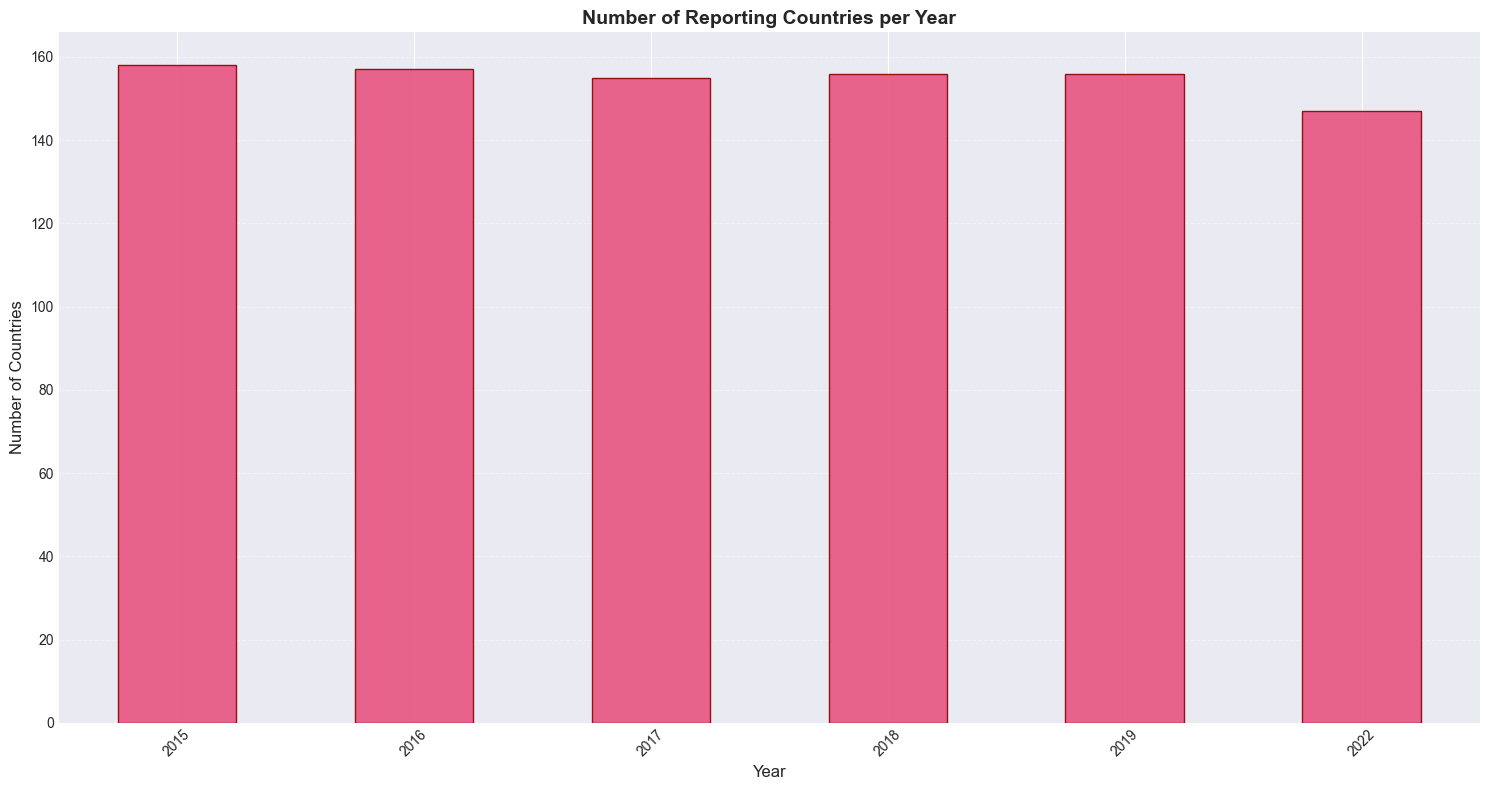

In [10]:
countries_per_year = df_combined.groupby('Year')['Country'].count()
print(countries_per_year)

plt.figure(figsize=(15, 8))

countries_per_year.plot(
    kind='bar',
    color='#e75480',     
    edgecolor='#8b0000', 
    alpha=0.9
)

plt.title(
    'Number of Reporting Countries per Year',
    fontsize=14,
    fontweight='bold'
)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Countries', fontsize=12)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

### F.2 Yearly Trends in Happiness Scores

          mean  median       std
Year                            
2015  5.375734  5.2325  1.145010
2016  5.382185  5.3140  1.141674
2017  5.354019  5.2790  1.131230
2018  5.375917  5.3780  1.119506
2019  5.407096  5.3795  1.113120
2022  5.553575  5.5685  1.086843


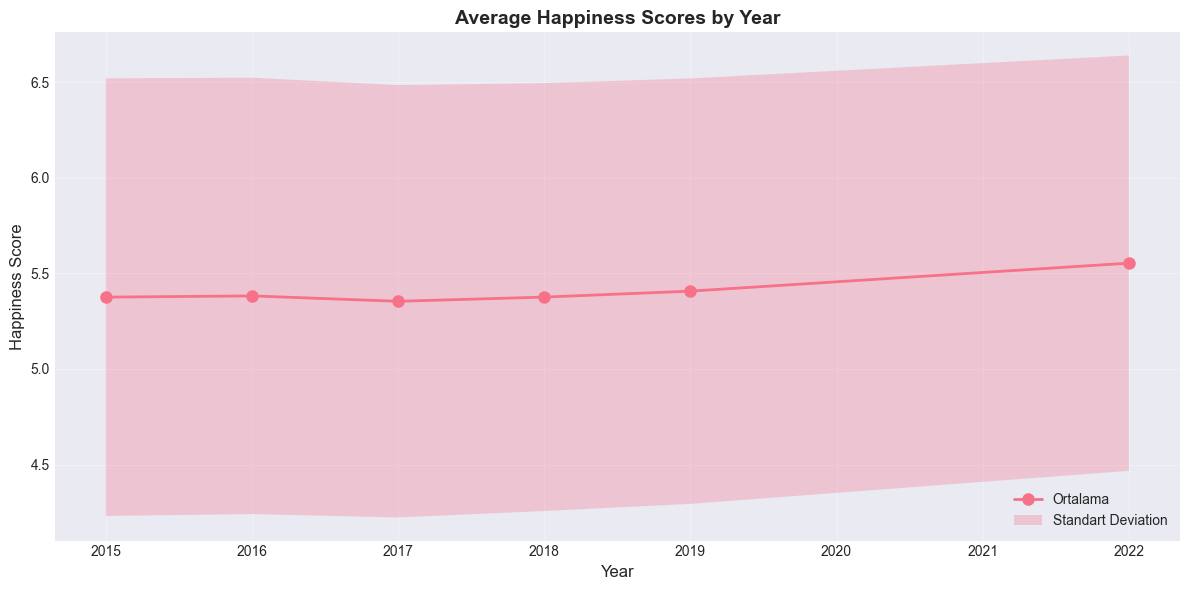


Happiest year: 2022 (Average: 5.554)
Least happy year: 2017 (Average: 5.354)


In [11]:
avg_happiness = df_combined.groupby('Year')['Happiness_Score'].agg(['mean', 'median', 'std'])
print(avg_happiness)

plt.figure(figsize=(12, 6))
plt.plot(avg_happiness.index, avg_happiness['mean'], marker='o', linewidth=2, markersize=8, label='Ortalama')
plt.fill_between(avg_happiness.index, 
                 avg_happiness['mean'] - avg_happiness['std'], 
                 avg_happiness['mean'] + avg_happiness['std'], 
                 alpha=0.3, label='Standart Deviation')
plt.title('Average Happiness Scores by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Happiness Score', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHappiest year: {avg_happiness['mean'].idxmax()} (Average: {avg_happiness['mean'].max():.3f})")
print(f"Least happy year: {avg_happiness['mean'].idxmin()} (Average: {avg_happiness['mean'].min():.3f})")

### F.3 Country-Level Happiness Rankings (2015–2022)


A total of 144 countries were analyzed (those with at least 5 years of data)

 The 10 Happiest Countries:
    Country  Average Happiness Score
    Finland                 7.585000
    Denmark                 7.561000
    Iceland                 7.518667
     Norway                 7.511667
Switzerland                 7.511500
Netherlands                 7.406333
     Sweden                 7.330000
     Canada                 7.296333
New Zealand                 7.294167
  Australia                 7.257167

 The 10 Least Happy Countries:
    Country  Average Happiness Score
   Zimbabwe                 3.838000
   Botswana                 3.830000
 Madagascar                 3.745400
       Togo                 3.638833
      Yemen                 3.625800
   Tanzania                 3.505333
     Rwanda                 3.438600
Afghanistan                 3.328000
      Syria                 3.292200
    Burundi                 3.079000


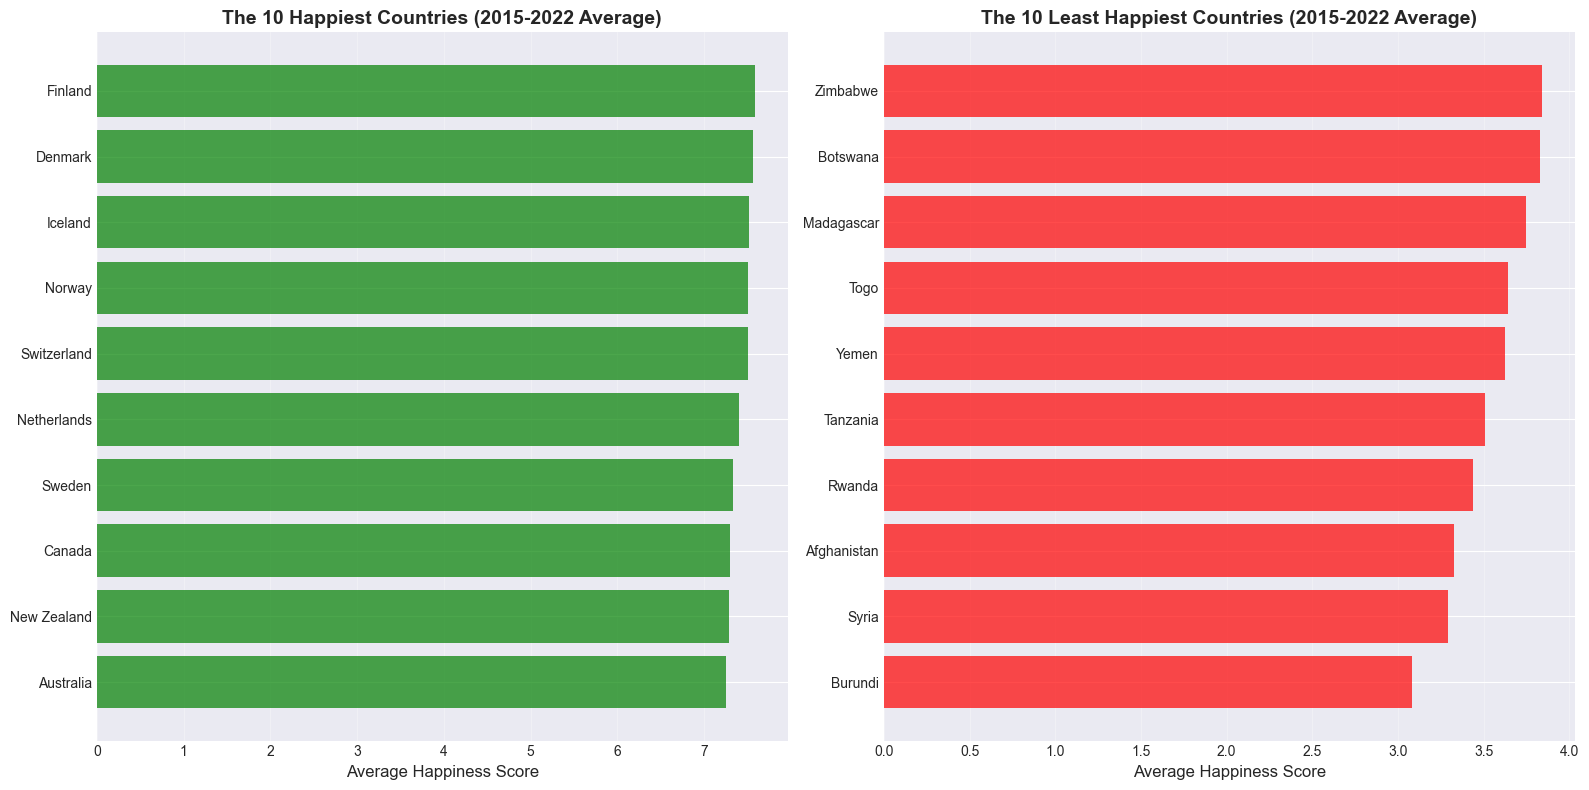

In [72]:
country_avg = df_combined.groupby('Country')['Happiness_Score'].agg(['mean', 'count']).reset_index()
country_avg = country_avg[country_avg['count'] >= 5]  
country_avg = country_avg.sort_values('mean', ascending=False)

print(f"\nA total of {len(country_avg)} countries were analyzed (those with at least 5 years of data)")

print("\n The 10 Happiest Countries:")
top_10_display = country_avg.head(10)[['Country', 'mean']].copy()
top_10_display.columns = ['Country', 'Average Happiness Score']
print(top_10_display.to_string(index=False))

print("\n The 10 Least Happy Countries:")
bottom_10_display = country_avg.tail(10)[['Country', 'mean']].copy()
bottom_10_display.columns = ['Country', 'Average Happiness Score']
print(bottom_10_display.to_string(index=False))


if len(country_avg) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    top_10 = country_avg.head(10).copy()
    if len(top_10) > 0:
        ax1.barh(range(len(top_10)), top_10['mean'].values, color='green', alpha=0.7)
        ax1.set_yticks(range(len(top_10)))
        ax1.set_yticklabels(top_10['Country'].values, fontsize=10)
        ax1.set_xlabel('Average Happiness Score', fontsize=12)
        ax1.set_title('The 10 Happiest Countries (2015-2022 Average)', fontsize=14, fontweight='bold')
        ax1.invert_yaxis()
        ax1.grid(axis='x', alpha=0.3)
    
    bottom_10 = country_avg.tail(10).copy()
    if len(bottom_10) > 0:
        ax2.barh(range(len(bottom_10)), bottom_10['mean'].values, color='red', alpha=0.7)
        ax2.set_yticks(range(len(bottom_10)))
        ax2.set_yticklabels(bottom_10['Country'].values, fontsize=10)
        ax2.set_xlabel('Average Happiness Score', fontsize=12)
        ax2.set_title('The 10 Least Happiest Countries (2015-2022 Average)', fontsize=14, fontweight='bold')
        ax2.invert_yaxis()
        ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data was found for visualization.")

### F.4 Yearly Extremes in Happiness Scores

In [73]:
for year in sorted(df_combined['Year'].unique()):
    year_data = df_combined[df_combined['Year'] == year].sort_values('Happiness_Score', ascending=False)
    happiest = year_data.iloc[0]
    least_happy = year_data.iloc[-1]
    
    print(f"\nYear {year}:")
    print(f"Happiest: {happiest['Country']} (Score: {happiest['Happiness_Score']:.3f})")
    print(f"Least Happy: {least_happy['Country']} (Score: {least_happy['Happiness_Score']:.3f})")


Year 2015:
Happiest: Switzerland (Score: 7.587)
Least Happy: Togo (Score: 2.839)

Year 2016:
Happiest: Denmark (Score: 7.526)
Least Happy: Burundi (Score: 2.905)

Year 2017:
Happiest: Norway (Score: 7.537)
Least Happy: Central African Republic (Score: 2.693)

Year 2018:
Happiest: Finland (Score: 7.632)
Least Happy: Burundi (Score: 2.905)

Year 2019:
Happiest: Finland (Score: 7.769)
Least Happy: South Sudan (Score: 2.853)

Year 2022:
Happiest: Finland (Score: 7.821)
Least Happy: xx (Score: nan)


### F.5 Distribution of Key Happiness Factors

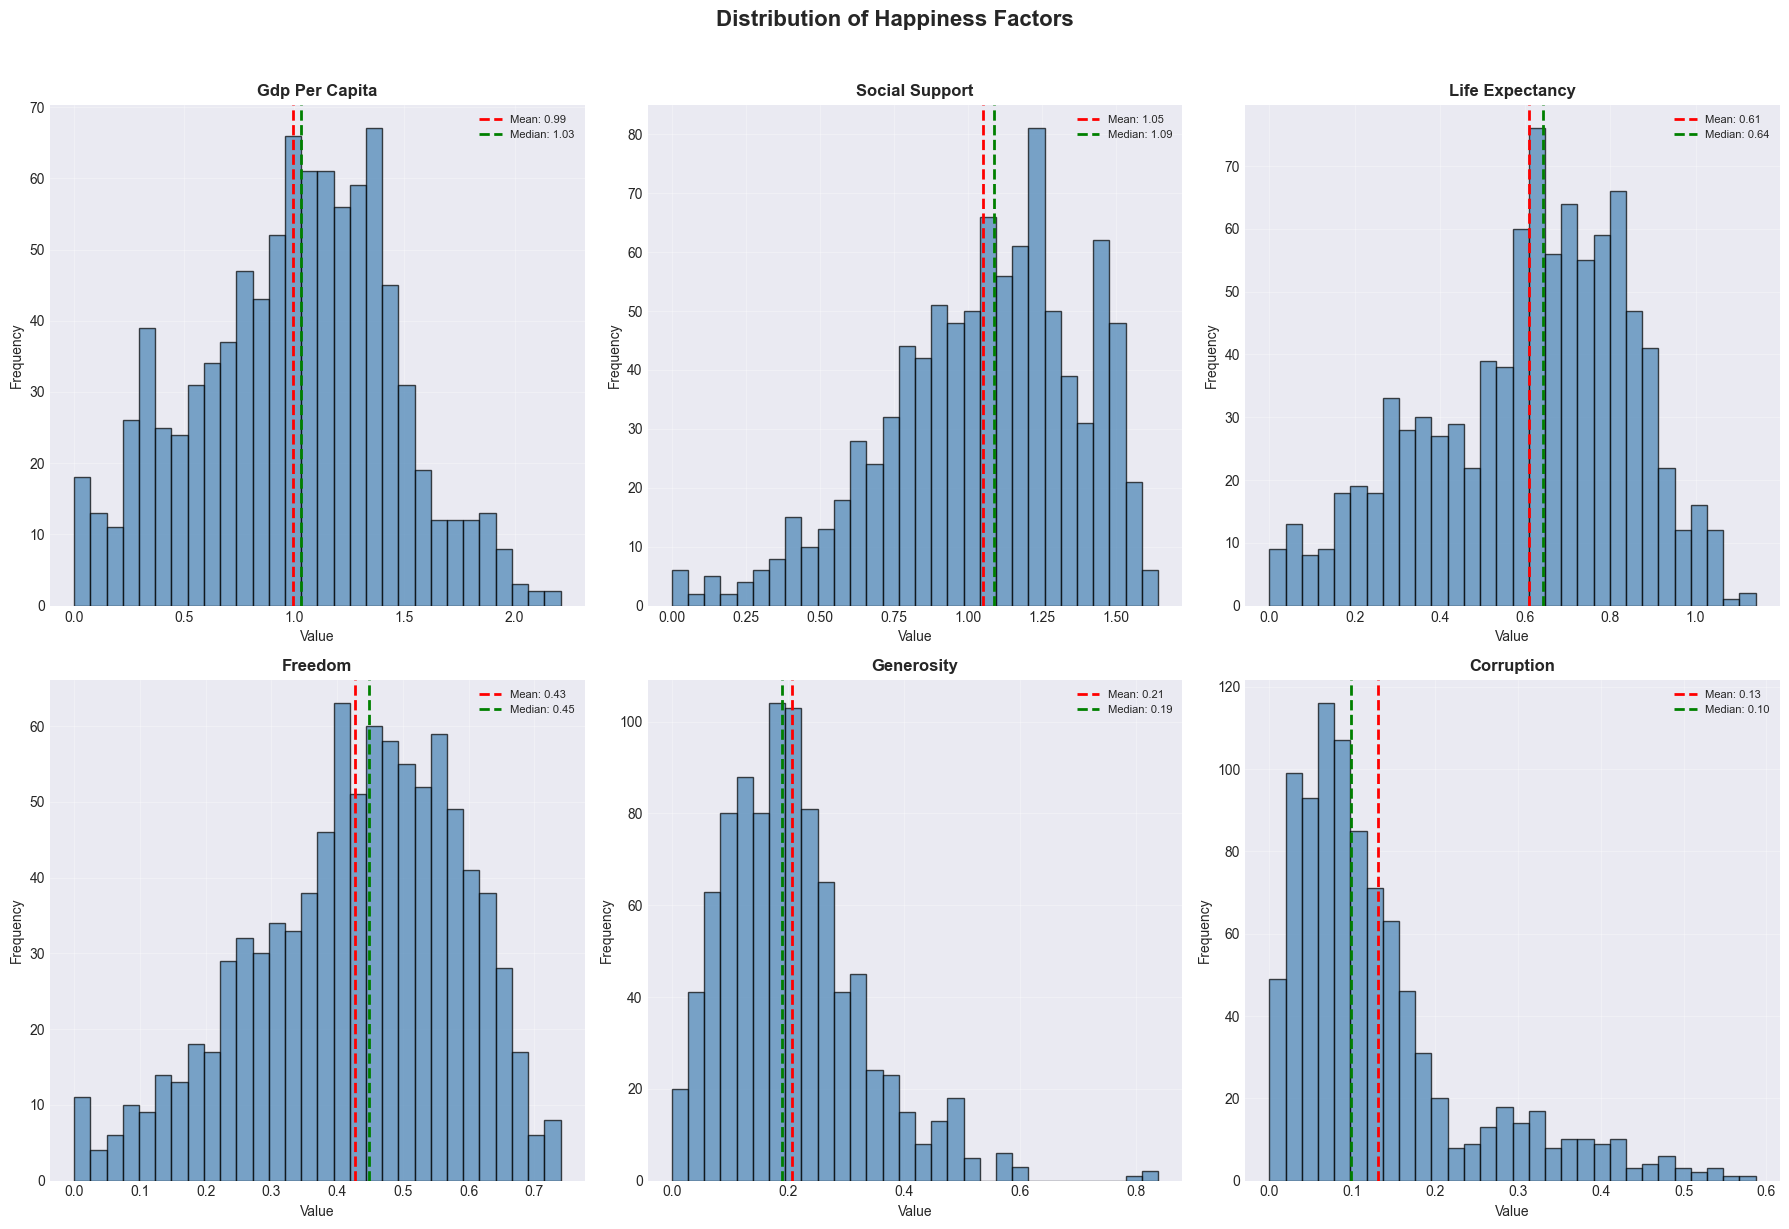

In [74]:
factors = ['GDP_per_capita', 'Social_support', 'Life_expectancy', 'Freedom', 'Generosity', 'Corruption']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, factor in enumerate(factors):
    if factor in df_combined.columns:
        axes[i].hist(df_combined[factor].dropna(), bins=30, color='steelblue', alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{factor.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Value', fontsize=10)
        axes[i].set_ylabel('Frequency', fontsize=10)
        axes[i].grid(alpha=0.3)
        
        mean_val = df_combined[factor].mean()
        median_val = df_combined[factor].median()
        axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
        axes[i].legend(fontsize=8)

plt.suptitle('Distribution of Happiness Factors', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### F.6 Temporal Changes in Happiness Factors

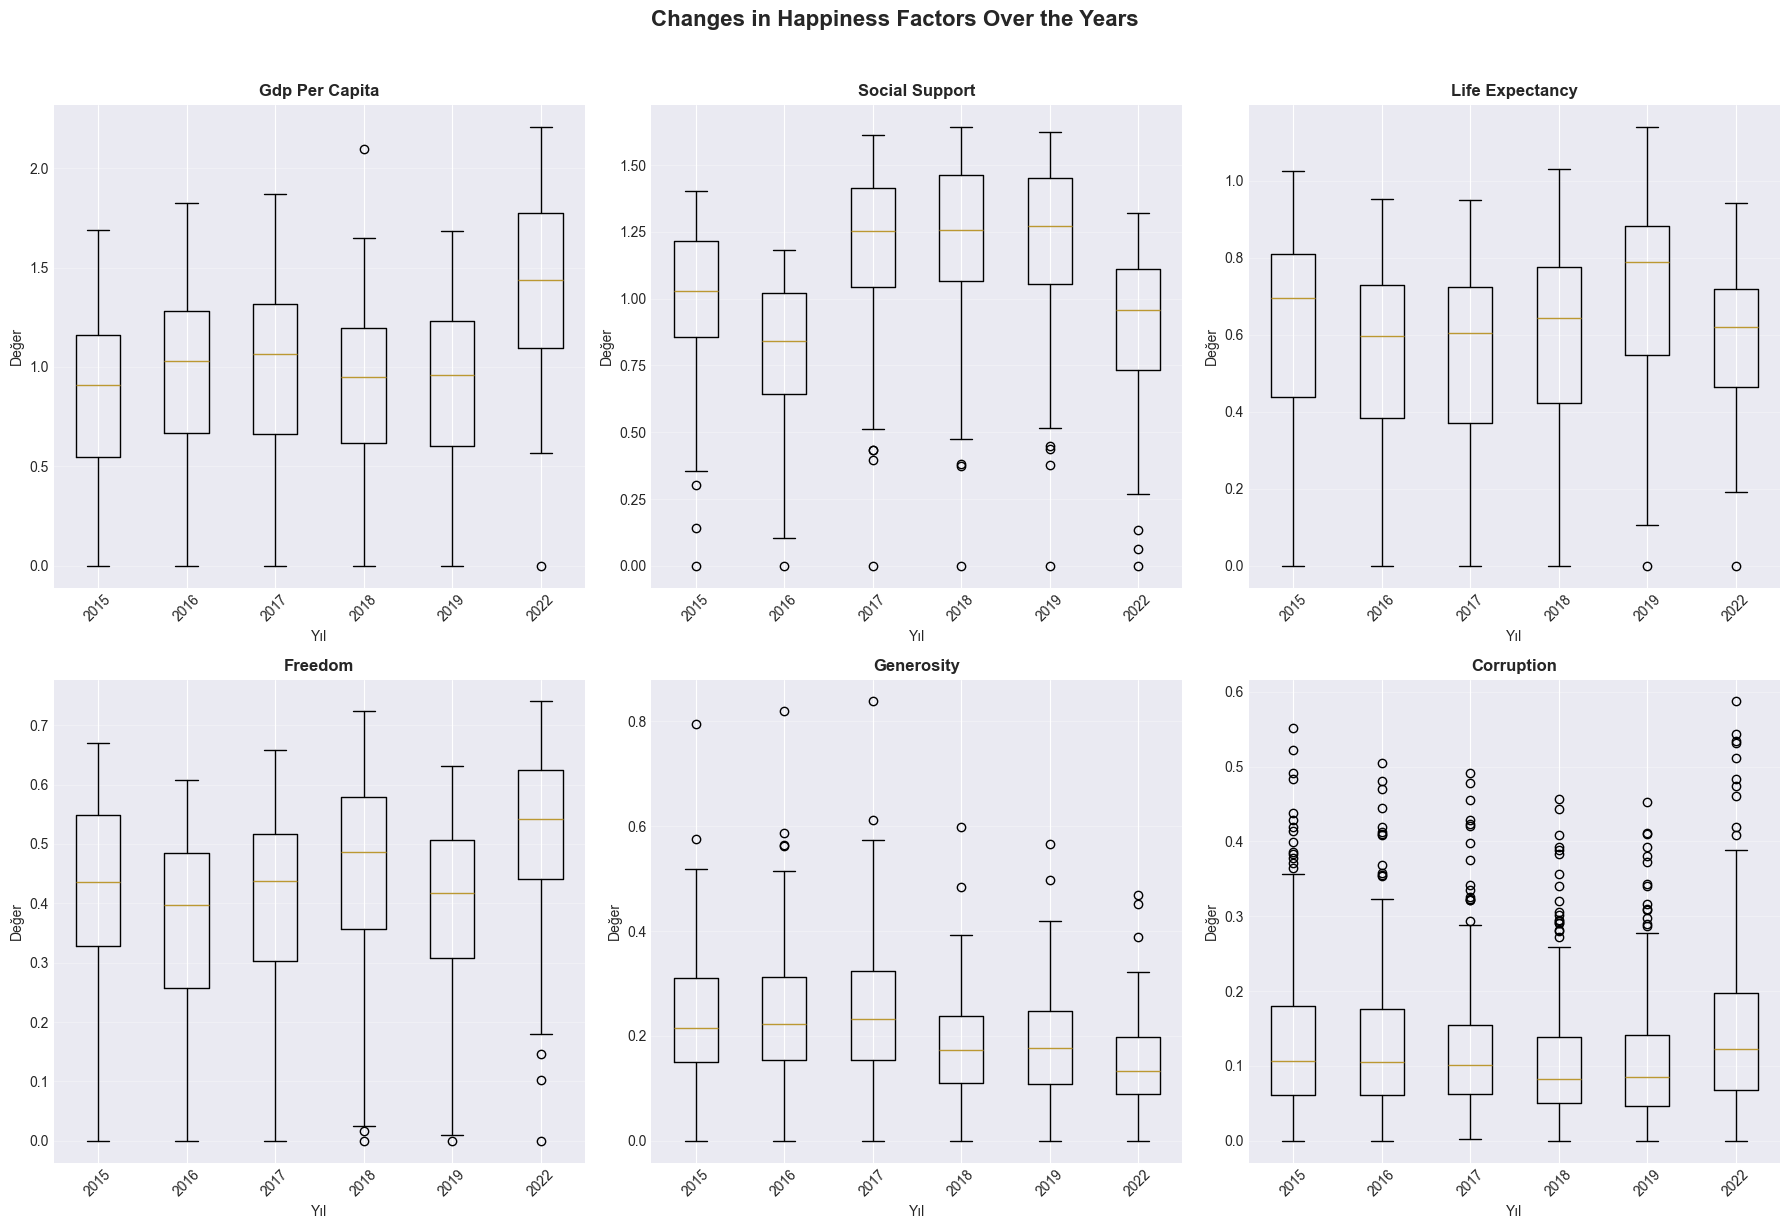

In [75]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, factor in enumerate(factors):
    if factor in df_combined.columns:
        box_data = [df_combined[df_combined['Year'] == year][factor].dropna() for year in sorted(df_combined['Year'].unique())]
        axes[i].boxplot(box_data, labels=sorted(df_combined['Year'].unique()))
        axes[i].set_title(f'{factor.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Yıl', fontsize=10)
        axes[i].set_ylabel('Değer', fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(alpha=0.3, axis='y')

plt.suptitle('Changes in Happiness Factors Over the Years', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## G. Correlation Analysis: Factors Strongly Associated with Happiness


Correlation Matrix:
                 Happiness_Score  GDP_per_capita  Social_support  \
Happiness_Score            1.000           0.740           0.641   
GDP_per_capita             0.740           1.000           0.465   
Social_support             0.641           0.465           1.000   
Life_expectancy            0.735           0.699           0.578   
Freedom                    0.558           0.418           0.359   
Generosity                 0.113          -0.116           0.009   
Corruption                 0.407           0.331           0.121   

                 Life_expectancy  Freedom  Generosity  Corruption  
Happiness_Score            0.735    0.558       0.113       0.407  
GDP_per_capita             0.699    0.418      -0.116       0.331  
Social_support             0.578    0.359       0.009       0.121  
Life_expectancy            1.000    0.328       0.010       0.258  
Freedom                    0.328    1.000       0.208       0.453  
Generosity                

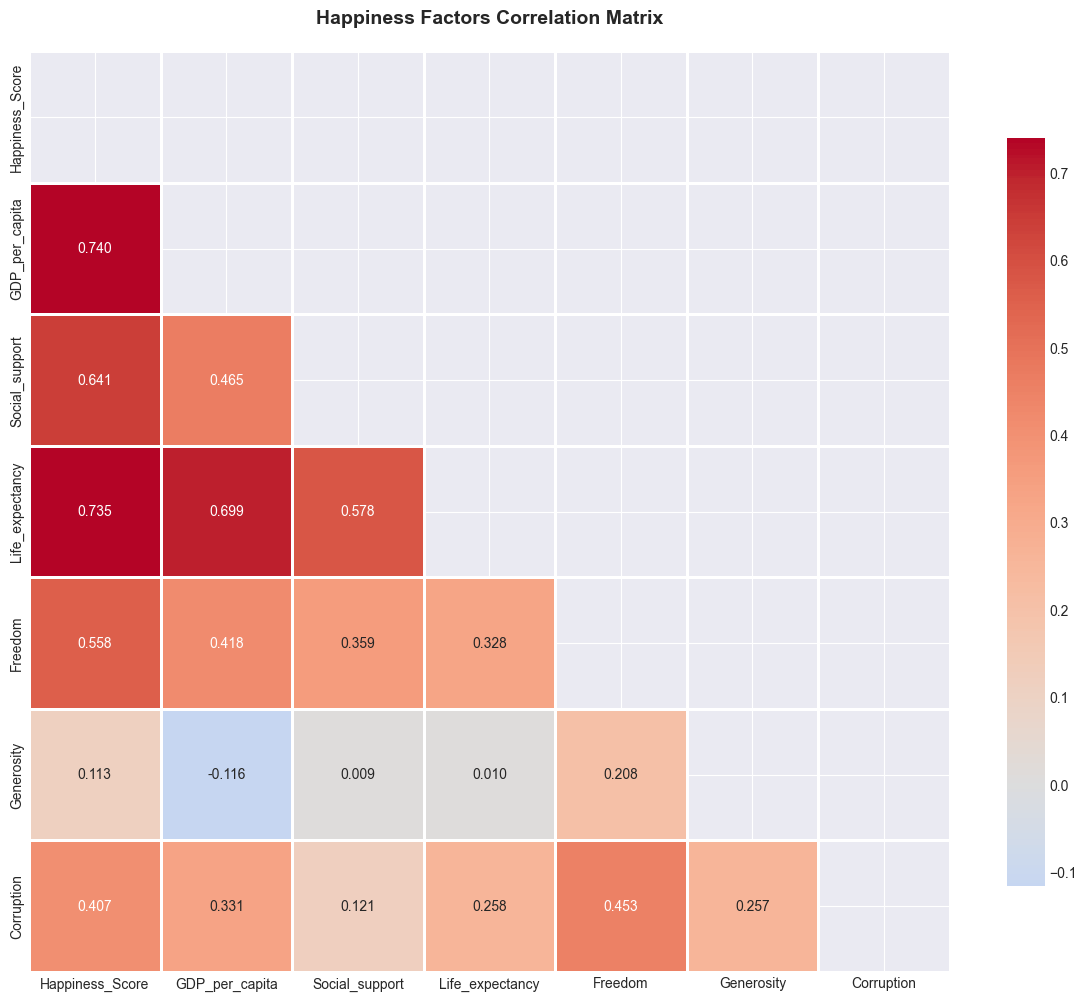

In [76]:
correlation_cols = ['Happiness_Score', 'GDP_per_capita', 'Social_support', 
                   'Life_expectancy', 'Freedom', 'Generosity', 'Corruption']

corr_matrix = df_combined[correlation_cols].corr()

print("\nCorrelation Matrix:")
print(corr_matrix.round(3))

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Üst üçgeni maskele
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, mask=mask)
plt.title('Happiness Factors Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


Correlation Values ​​(with Happiness Score):
Gdp Per Capita: 0.740
Life Expectancy: 0.735
Social Support: 0.641
Freedom: 0.558
Corruption: 0.407
Generosity: 0.113


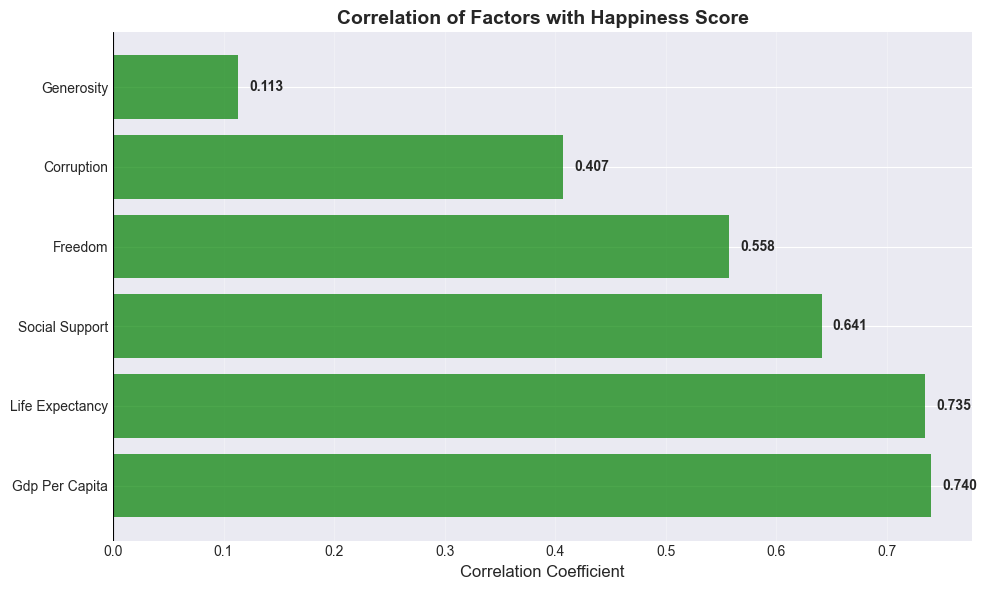


Strongest positive correlation: Gdp Per Capita (0.740)
Strongest negative correlation: Generosity (0.113)


In [77]:
happiness_corr = corr_matrix['Happiness_Score'].drop('Happiness_Score').sort_values(ascending=False)

print("\nCorrelation Values ​​(with Happiness Score):")
for factor, corr in happiness_corr.items():
    print(f"{factor.replace('_', ' ').title()}: {corr:.3f}")

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in happiness_corr.values]
bars = plt.barh(range(len(happiness_corr)), happiness_corr.values, color=colors, alpha=0.7)
plt.yticks(range(len(happiness_corr)), [f.replace('_', ' ').title() for f in happiness_corr.index])
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.title('Correlation of Factors with Happiness Score', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, happiness_corr.values)):
    plt.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}', 
             va='center', ha='left' if val > 0 else 'right', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nStrongest positive correlation: {happiness_corr.idxmax().replace('_', ' ').title()} ({happiness_corr.max():.3f})")
print(f"Strongest negative correlation: {happiness_corr.idxmin().replace('_', ' ').title()} ({happiness_corr.min():.3f})")

## H. Exploratory Analysis of Happiness Drivers

### H.1 Relationship Between Happiness Score and Key Factors

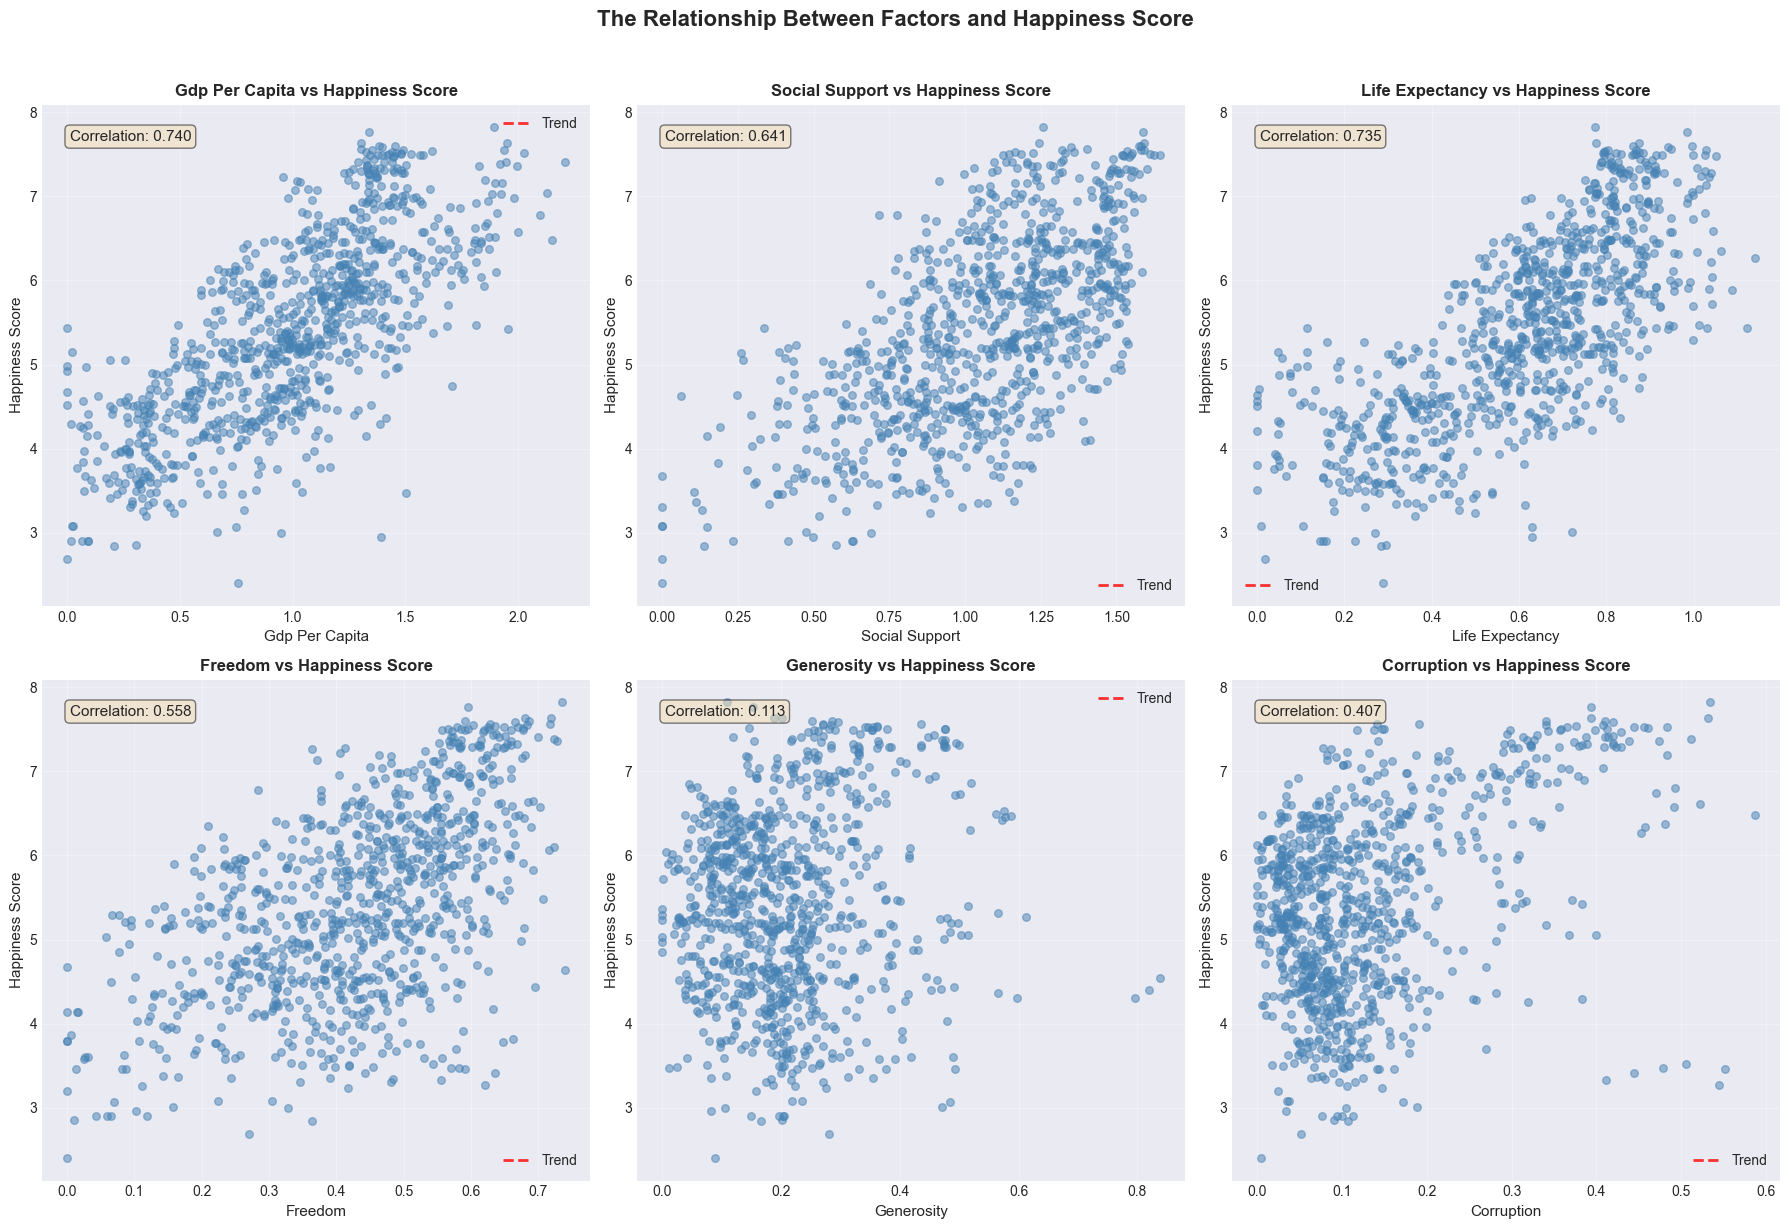

In [78]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, factor in enumerate(factors):
    if factor in df_combined.columns:

        axes[i].scatter(df_combined[factor], df_combined['Happiness_Score'], 
                       alpha=0.5, s=30, color='steelblue')
        

        z = np.polyfit(df_combined[factor].dropna(), 
                      df_combined.loc[df_combined[factor].notna(), 'Happiness_Score'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df_combined[factor].min(), df_combined[factor].max(), 100)
        axes[i].plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label='Trend')
        

        corr = df_combined[[factor, 'Happiness_Score']].corr().iloc[0, 1]
        axes[i].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                    transform=axes[i].transAxes, fontsize=11,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        axes[i].set_xlabel(factor.replace('_', ' ').title(), fontsize=11)
        axes[i].set_ylabel('Happiness Score', fontsize=11)
        axes[i].set_title(f'{factor.replace("_", " ").title()} vs Happiness Score', 
                         fontsize=12, fontweight='bold')
        axes[i].legend()
        axes[i].grid(alpha=0.3)

plt.suptitle('The Relationship Between Factors and Happiness Score', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### H.2 Top vs Bottom 10 Countries: Factor Comparison (2022)

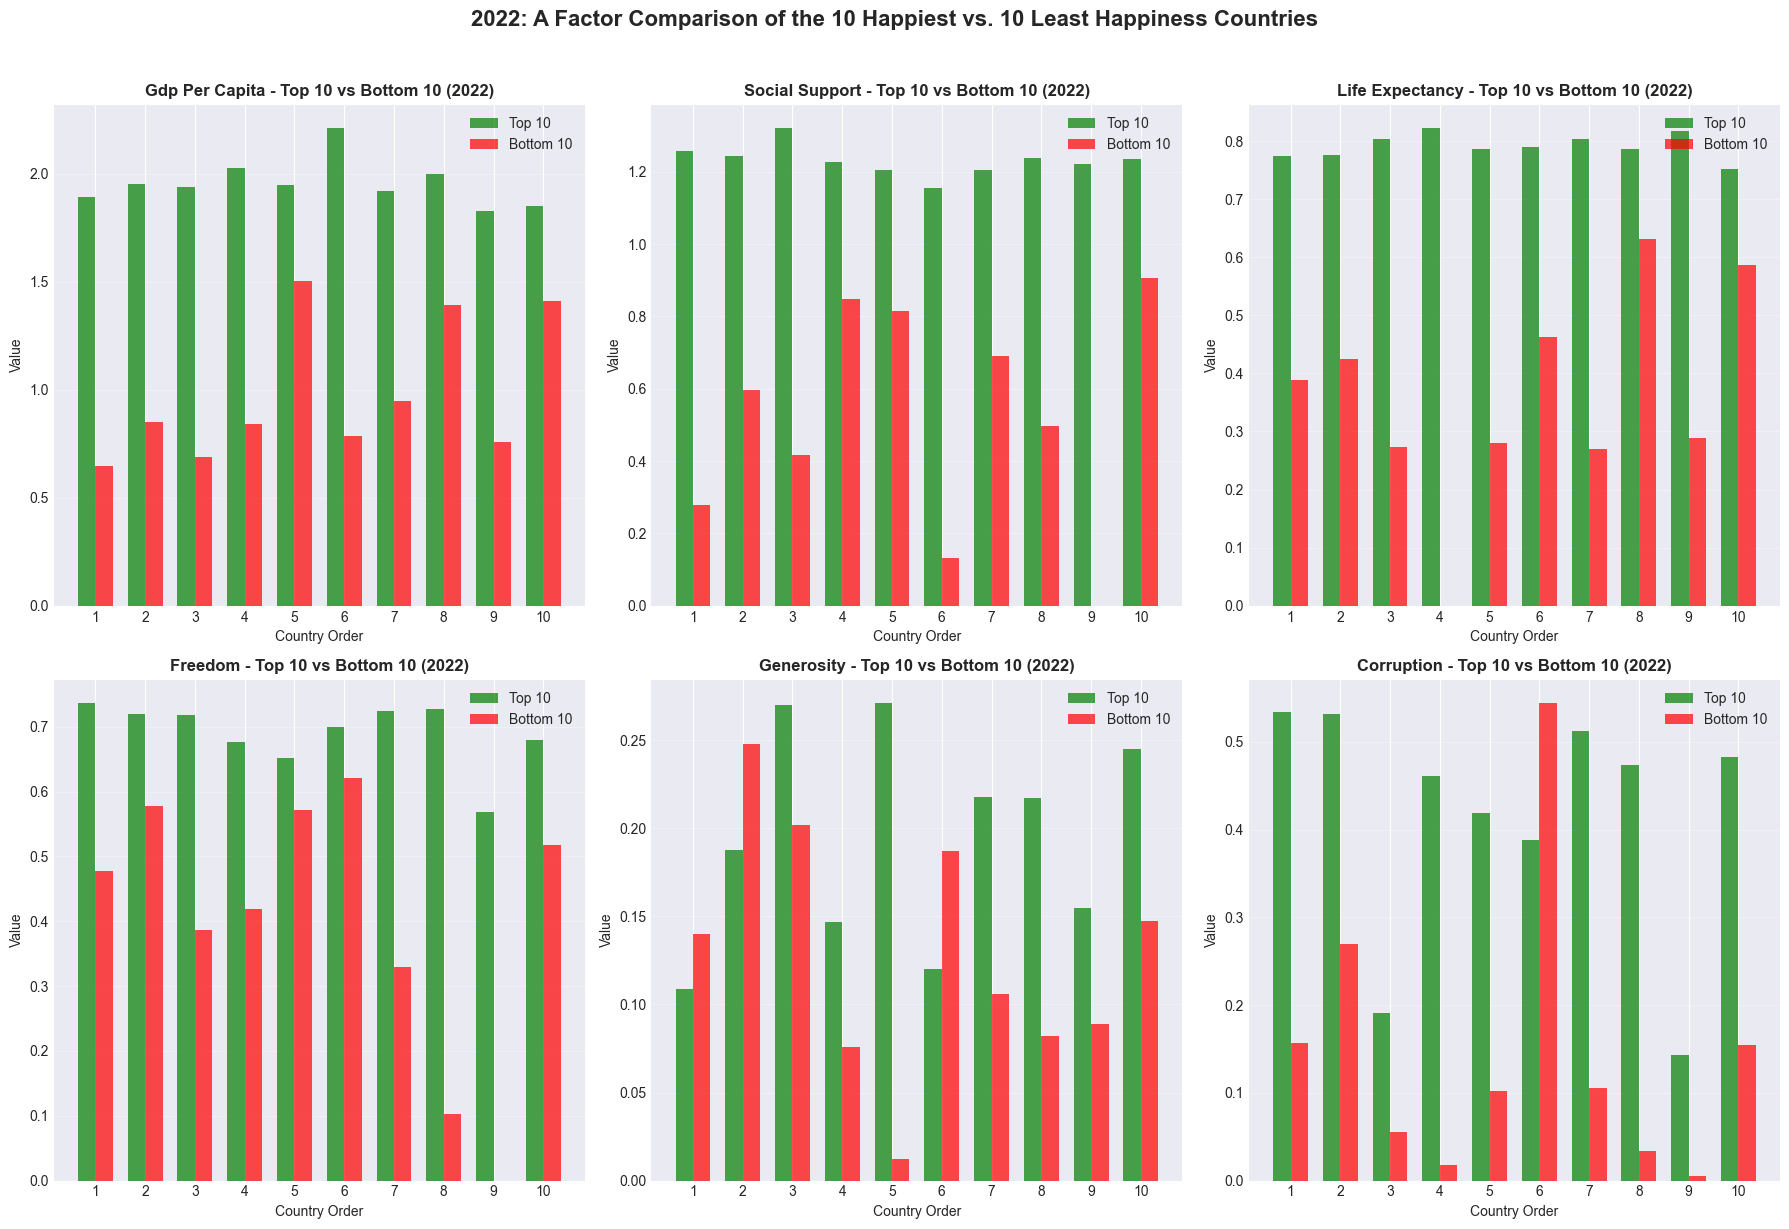

In [79]:
year_2022 = df_combined[df_combined['Year'] == 2022].sort_values('Happiness_Score', ascending=False)
top_10_2022 = year_2022.head(10)
bottom_10_2022 = year_2022.tail(10)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, factor in enumerate(factors):
    if factor in df_combined.columns:
        x_pos = np.arange(len(top_10_2022))
        width = 0.35
        
        axes[i].bar(x_pos - width/2, top_10_2022[factor].values, width, 
                   label='Top 10', color='green', alpha=0.7)
        axes[i].bar(x_pos + width/2, bottom_10_2022[factor].values, width, 
                   label='Bottom 10', color='red', alpha=0.7)
        
        axes[i].set_xlabel('Country Order', fontsize=10)
        axes[i].set_ylabel('Value', fontsize=10)
        axes[i].set_title(f'{factor.replace("_", " ").title()} - Top 10 vs Bottom 10 (2022)', 
                         fontsize=12, fontweight='bold')
        axes[i].legend()
        axes[i].grid(alpha=0.3, axis='y')
        axes[i].set_xticks(x_pos)
        axes[i].set_xticklabels(range(1, 11), rotation=0)

plt.suptitle('2022: A Factor Comparison of the 10 Happiest vs. 10 Least Happiness Countries', 
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### H.3 Happiness Trends Over Time for Selected Countries

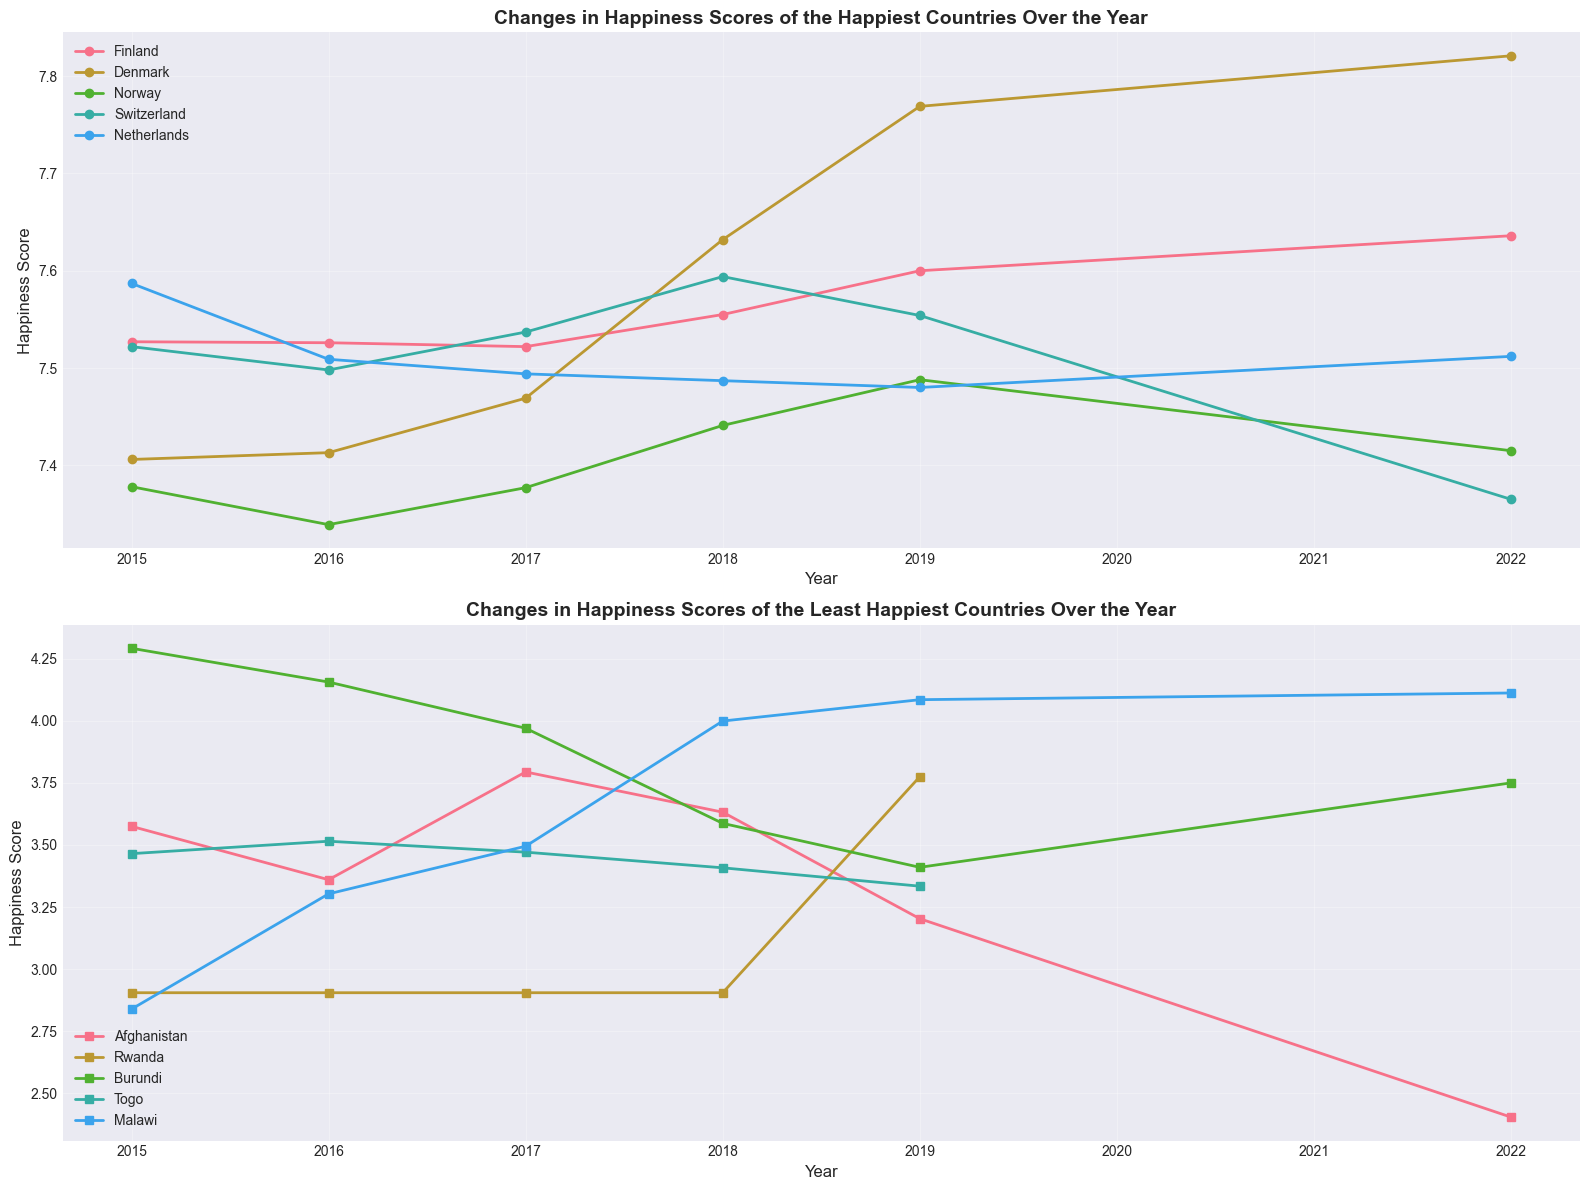

In [80]:
selected_countries = ['Finland', 'Denmark', 'Norway', 'Switzerland', 'Netherlands', 
                     'United States', 'Germany', 'United Kingdom', 'Japan', 'India',
                     'Afghanistan', 'Rwanda', 'Burundi', 'Togo', 'Malawi']

available_countries = [c for c in selected_countries if c in df_combined['Country'].values]

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

top_countries = ['Finland', 'Denmark', 'Norway', 'Switzerland', 'Netherlands']
top_data = df_combined[df_combined['Country'].isin(top_countries)]

axes[0].plot(top_data.groupby(['Year', 'Country'])['Happiness_Score'].mean().unstack(), 
            marker='o', linewidth=2, markersize=6)
axes[0].set_title('Changes in Happiness Scores of the Happiest Countries Over the Year', 
                 fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Happiness Score', fontsize=12)
axes[0].legend(top_countries, loc='best')
axes[0].grid(alpha=0.3)

# En az mutlu ülkeler
bottom_countries = ['Afghanistan', 'Rwanda', 'Burundi', 'Togo', 'Malawi']
bottom_data = df_combined[df_combined['Country'].isin(bottom_countries)]

axes[1].plot(bottom_data.groupby(['Year', 'Country'])['Happiness_Score'].mean().unstack(), 
            marker='s', linewidth=2, markersize=6)
axes[1].set_title('Changes in Happiness Scores of the Least Happiest Countries Over the Year', 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Happiness Score', fontsize=12)
axes[1].legend(bottom_countries, loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## I. Exporting Cleaned Data for Tableau

In [84]:
output_dir = '/Users/melisatay/Desktop/happiness-portfolio-project'
os.makedirs(output_dir, exist_ok=True)

output_file = f'{output_dir}/world_happiness_cleaned.csv'
df_combined.to_csv(output_file, index=False, encoding='utf-8-sig')

for i, col in enumerate(df_combined.columns, 1):
    print(f"  {i}. {col}")

  1. Year
  2. Country
  3. Rank
  4. Happiness_Score
  5. GDP_per_capita
  6. Social_support
  7. Life_expectancy
  8. Freedom
  9. Generosity
  10. Corruption
